### Do not run the first 3 cells if this notebook is not at the Google Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
%cd drive/MyDrive/Registration/

In [ ]:
!pip install neurite

In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

import random
import math

import layers as custom_layers

In [2]:
fixed_img_ph = np.zeros((64, 256, 256))
fixed_img_ph[3:60, 29:225, 29:225] = 1
fixed_img_ph = np.asarray(fixed_img_ph).astype(np.float32)

In [3]:
fixed_img_ph = np.expand_dims(fixed_img_ph, axis=-1)
fixed_img_ph = np.expand_dims(fixed_img_ph, axis=0)

In [4]:
# Get rid of the batch dimension
img_input = keras.Input(shape = list(fixed_img_ph.shape)[1:])
print(img_input.shape)
affine_input = keras.Input(shape = (12,))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, shift_center=True)([img_input, affine_input])
print(affine_warped.shape)

(None, 64, 256, 256, 1)
Instructions for updating:
Use fn_output_signature instead
(None, 64, 256, 256, 1)


In [5]:
model = keras.Model(inputs=[img_input, affine_input], outputs=affine_warped, name="affine_transformation")
model.summary()

Model: "affine_transformation"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 256, 256 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
spatial_transformer (SpatialTra (None, 64, 256, 256, 0           input_1[0][0]                    
                                                                 input_2[0][0]                    
Total params: 0
Trainable params: 0
Non-trainable params: 0
__________________________________________________________________________________________________


In [6]:
def random_transform(fixed_img):
    '''
    Takes a fixed image and apply random affine transformation to it.
    
    fixed_img: Tensor: shape (1, W, H, D, 1)
    
    return: warped_img:  Tensor: shape(1, W, H, D, 1)
            affine_param: ndarray: shape: (12,), this is the transformation parameter
                                   we need to transform moving image back to the fixed image. 
    '''
    translation = np.eye(4)
    rotX = np.eye(4)
    rotY = np.eye(4)
    rotZ = np.eye(4)
    scaling = np.eye(4)

    # Constants
    xTranslationRange = 5
    yTranslationRange = 30
    zTranslationRange = 30
    xRotAngle = math.pi / random.uniform(8, 80)
    yRotAngle = math.pi / random.uniform(40, 160)
    zRotAngle = math.pi / random.uniform(40, 160)
    scalingX = random.uniform(0.85, 1.15)
    scalingY = random.uniform(0.85, 1.15)
    scalingZ = random.uniform(0.85, 1.15)
    
    # Calculate affine transformation matrix
    translation[0, 3] = xTranslationRange * random.random()
    translation[1, 3] = yTranslationRange * random.random()
    translation[2, 3] = zTranslationRange * random.random()

    rotX[1, 1] = math.cos(xRotAngle)
    rotX[1, 2] = math.sin(xRotAngle)
    rotX[2, 1] = -math.sin(xRotAngle)
    rotX[2, 2] = math.cos(xRotAngle)

    rotY[0, 0] = math.cos(yRotAngle)
    rotY[0, 2] = -math.sin(yRotAngle)
    rotY[2, 0] = math.sin(yRotAngle)
    rotY[2, 2] = math.cos(yRotAngle)

    rotZ[0, 0] = math.cos(zRotAngle)
    rotZ[0, 1] = -math.sin(zRotAngle)
    rotZ[1, 0] = math.sin(zRotAngle)
    rotZ[1, 1] = math.cos(zRotAngle)

    scaling[0, 0] = scalingX
    scaling[1, 1] = scalingY
    scaling[2, 2] = scalingZ

    transMat = translation @ rotZ @ rotY @ rotX @ scaling

    # Affine transformation parameters to feed into VoxelMorph's transformation layer.
    affine_param = transMat[0:3].flatten()
    affine_param = np.expand_dims(affine_param, axis=0)

    warped_img = model([fixed_img, affine_param])
    
    transMat_inv = np.linalg.inv(transMat)
    affine_param_inv = transMat_inv[0:3].flatten().astype(np.float32)
    
    return warped_img, affine_param_inv

### For testing purposes: check random transformed image samples

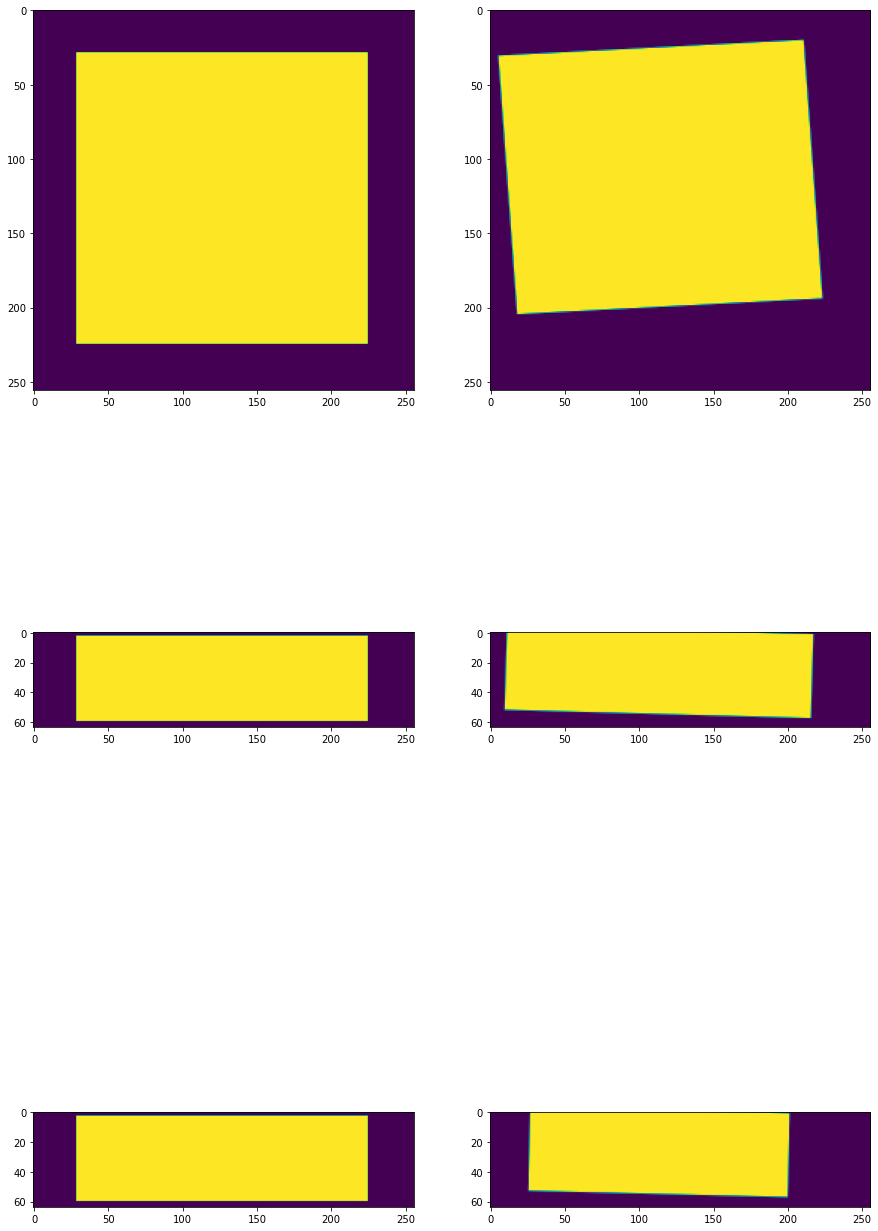

In [7]:
warped_img_test, _ = random_transform(fixed_img_ph)
sliceToCheck_x = 25
sliceToCheck_y = 100
sliceToCheck_z = 100
fig, axs = plt.subplots(3, 2, figsize=(15, 25))
axs[0, 0].imshow(fixed_img_ph[0, sliceToCheck_x, :, :, 0])
axs[0, 1].imshow(warped_img_test[0, sliceToCheck_x, :, :, 0])
axs[1, 0].imshow(fixed_img_ph[0, :, sliceToCheck_y, :, 0])
axs[1, 1].imshow(warped_img_test[0, :, sliceToCheck_y, :, 0])
axs[2, 0].imshow(fixed_img_ph[0, :, :, sliceToCheck_z, 0])
axs[2, 1].imshow(warped_img_test[0, :, :, sliceToCheck_z, 0])

### Loop to generate training dataset

In [8]:
num_pairs = 50
single_fixed_img = False # True will make dataset only contain 1 fixed image; False otherwise.
for i in range(num_pairs):
    fixed_img = fixed_img_ph
    path = "./ToyTrainingData1/toy_affine{}.npz"
    if not single_fixed_img:
        path = "./ToyTrainingData2/toy_affine{}.npz"
        fixed_img, _ = random_transform(fixed_img_ph)
    
    warped_img, affine_param = random_transform(fixed_img)
    img_pair = tf.concat([fixed_img, warped_img], axis=-1)
    
    f = open(path.format(i), "wb")
    np.savez(f, img_pair = img_pair, trf = affine_param)
    f.close()
    if (i % 10 == 0):
        print("Milestone: file {} has been saved.".format(i))

Milestone: file 0 has been saved.
Milestone: file 10 has been saved.
Milestone: file 20 has been saved.
Milestone: file 30 has been saved.
Milestone: file 40 has been saved.


### Load and inspect random samples from generated dataset.

In [23]:
num_pairs = 50
path = "./ToyTrainingData2/toy_affine{}.npz"
rand_idx = random.randrange(num_pairs)
sample_obj = np.load(path.format(rand_idx))
img_pair = sample_obj['img_pair']
affine_param = sample_obj['trf']

In [24]:
# print(img_pair.shape)
# print(affine_param.shape)

In [25]:
fixed_img_sample = np.expand_dims(img_pair[:, :, :, :, 0], axis=-1)
moving_img_sample = np.expand_dims(img_pair[:, :, :, :, 1], axis=-1)
recon_img_sample = model([moving_img_sample, affine_param])

In [26]:
print(fixed_img_sample.shape)
print(moving_img_sample.shape)
print(recon_img_sample.shape)

(1, 64, 256, 256, 1)
(1, 64, 256, 256, 1)
(1, 64, 256, 256, 1)


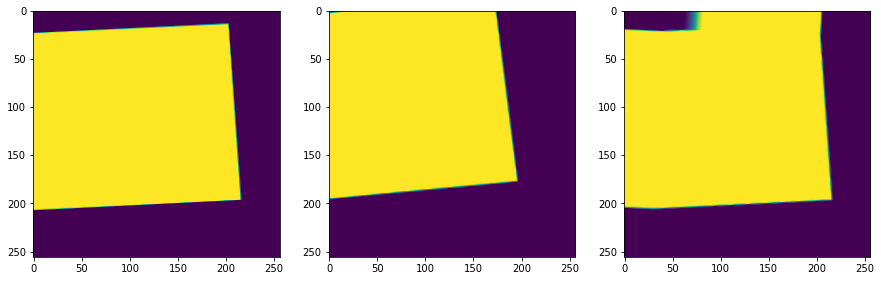

In [27]:
slice_idx_x = 30
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs[0].imshow(fixed_img_sample[0, slice_idx_x, :, :, 0])
axs[1].imshow(moving_img_sample[0, slice_idx_x, :, :, 0])
axs[2].imshow(recon_img_sample[0, slice_idx_x, :, :, 0])